### [Source code documentation for reference - TFQ](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds)

In [158]:

import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
from cirq.contrib.svg import SVGCircuit

SyntaxError: invalid syntax (<ipython-input-158-f86534172fda>, line 1)

## Get my hands dirty with methods

In [93]:
a = sympy.symbols('a')
q0, q1 = cirq.GridQubit.rect(1, 2)

In [94]:
# A simple circuit with CNOT gate
circuit = cirq.Circuit(cirq.rx(a).on(q0), cirq.CNOT(control=q0, target=q1))

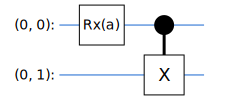

In [95]:
SVGCircuit(circuit)

In [97]:
# Final state vector by collapsing the wave function
wavefunction = cirq.ParamResolver({a:0.2})
output_state_vector = cirq.Simulator().simulate(circuit, wavefunction).final_state

In [98]:
output_state_vector

array([0.9950042+0.j        , 0.       +0.j        ,
       0.       +0.j        , 0.       -0.09983341j], dtype=complex64)

In [103]:
# Converting the cirq circuit to quantum tensor
circuit_tensor = tfq.convert_to_tensor([circuit])

In [104]:
print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


## Create a quantum Layer

In [125]:
# Out = 0.5 * Pauli.Z gate(input1) + Pauli.X(input2)

a = sympy.symbols('a')
q0, q1 = cirq.GridQubit.rect(1, 2)

# Define the list of operations
ops = [-1.0 * cirq.Z(q0), cirq.X(q0) + 2.0 * cirq.Z(q1)] 

# generate a batch of values for parameters a 
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 1)), dtype=np.float32)

# Instantiate the circuit
circuit = cirq.Circuit(cirq.X(q0)**a , cirq.Y(q1)**a)


In [130]:
# It returns an array of expectation values since the expectation layer 
# has circuit run over a batch of symbol values.

tfq.layers.Expectation()(circuit,
                         symbol_names=[a],
                         symbol_values=batch_vals,
                         operators = ops)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.44041085, -0.8808217 ],
       [ 0.94158864, -1.8831773 ],
       [ 0.73876166, -1.4775233 ],
       [ 0.144711  , -0.289422  ],
       [ 0.69098794, -1.3819759 ]], dtype=float32)>

## Hybrid Quantum-classic neural net

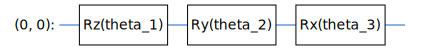

In [146]:
# Example taken up from tensorflow quantum tutorial 

# Controlled circuit defintion 

# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [147]:
# Controller circuit i.e. the classic NN

controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])


In [148]:
# Connect the controller to the controlled network i.e quantum circuit

circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')




In [149]:
controller_output = controller(commands_input)

expectation_layer = tfq.layers.ControlledPQC(model_circuit,operators = cirq.Z(qubit))

In [150]:
expectation = expectation_layer([circuits_input, controller_output])

# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

In [151]:
# Prepare Input, output and dataset

# Input values to the classic NN 
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [152]:
# Generate quantum rotation values as the data points to the circuit
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)

In [153]:
# feed the inputs controller and the quantum generate data to the model 
model([datapoint_circuits, commands]).numpy()

array([[0.6435821],
       [0.6167484]], dtype=float32)

In [156]:
# Define the training process...

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
model.summary()
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
commands_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
circuits_input (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3)            53          commands_input[0][0]             
__________________________________________________________________________________________________
controlled_pqc_2 (ControlledPQC (None, 1)            0           circuits_input[0][0]             
                                                                 sequential_1[0][0]         

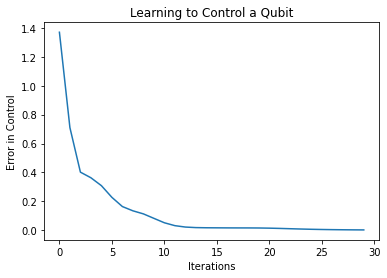

In [155]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()